## Imports

In [ ]:
!pip install strsimpy
!pip install pyphonetics
!pip install transformers
!pip install datasets

In [ ]:
from google.colab import drive
import torch
drive.mount('/content/gdrive', force_remount=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from pyphonetics import Metaphone, Soundex, RefinedSoundex, Lein, FuzzySoundex
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.cosine import Cosine
from strsimpy.qgram import QGram
from strsimpy.damerau import Damerau
from torch import nn
import numpy as np
import pandas as pd
import spacy
import string
from transformers import BertForMaskedLM, BertForTokenClassification, BertTokenizerFast
import nltk

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('words')

## Mask words using BERT based token classification model
We have fine-tuned a BERT model for performing token classification. This model predicts which tokens should be masked in the un-normalized text

In [ ]:
model_name = 'bert-base-uncased'

bert_token_clsfr = BertForTokenClassification.from_pretrained("/content/gdrive/MyDrive/685/models/predict_masks", num_labels=2).to(device)
bert_tokenizer_fast = BertTokenizerFast.from_pretrained(model_name)

bert_mask_model = BertForMaskedLM.from_pretrained(model_name)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_mask_words_ids(unnorm_text):
    x = bert_tokenizer_fast(unnorm_text, return_tensors='pt')
    input_ids = x['input_ids'].to(device)
    attention_mask = x['attention_mask'].to(device)
    token_ids = x['token_type_ids'].to(device)
    logits = bert_token_clsfr(input_ids, attention_mask=attention_mask, token_type_ids=token_ids).logits.squeeze()

    probs = torch.softmax(logits, dim=1).squeeze().cpu().detach().numpy()
    words_ids = x.word_ids()
    return probs, words_ids

def get_masked_sentence(norm_text, unnorm_text):
    norm_words = nltk.word_tokenize(norm_text)
    unnorm_words = nltk.word_tokenize(unnorm_text)
    if len(norm_words) != len(unnorm_words):
        return None
    probs, words_ids = get_mask_words_ids(unnorm_text)
    n = probs.shape[0]
    masked_words, gt_words = [], []

    added = set()
    for i in range(n):
        if probs[i][1] >= 0.5:
            if words_ids[i] not in added:
                masked_words.append(unnorm_words[words_ids[i]])
                gt_words.append(norm_words[words_ids[i]])
                unnorm_words[words_ids[i]] = '[MASK]'
                added.add(words_ids[i])
    return " ".join(unnorm_words), masked_words, gt_words

## Mask out of vocabulary and out of context words using ELECTRA

We have also tried using ELECTRA discriminator to find the out-of-context words in the sentences and mask them. Here we use NLTK's and Spacy's vocabulary to mask out-of-vocabulary tokens.

In [ ]:
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from transformers import ElectraForPreTraining, ElectraTokenizerFast
import multiprocessing

nlp = spacy.load('en_core_web_sm')
vocab_words = set(nlp.vocab.strings)
for punc in  string.punctuation:
  vocab_words.add(punc)

words_final = set(words.words())

model_name = "google/electra-small-discriminator"
discriminator = ElectraForPreTraining.from_pretrained(model_name).to(device)
tokenizer = ElectraTokenizerFast.from_pretrained(model_name)

def init(_lock):
    global lock
    lock = _lock

def mask_oov_and_ooc_words(inputs):
  lock = multiprocessing.Lock()
  pool = multiprocessing.Pool(initializer=init, initargs=(lock,))
  oov_masked = pool.map(mask_oov_in_text, inputs)
  oov_masked = []
  for text in inputs:
      oov_masked.append(mask_oov_in_text(text))
  masked_sentences = []
  for text in oov_masked:
    masked_sentences.append(mask_ooc_in_text(text))
  return masked_sentences

# special cases
replace_dict = {'u':'you','u.':'you.','m':'am','d':'the','y':'why','nt':'not','c':'see','ur':'your','r':'are'}
def mask_oov_in_text(text):
  text=nlp(text)
  masked_text = ''
  for word in text:
    word = str(word)
    if word.lower() in list(replace_dict.keys()):
      masked_text = masked_text+' '+replace_dict[word.lower()]
    elif word.lower() == 'wit':
      masked_text = masked_text+' '+tokenizer.mask_token
    elif word in vocab_words or word in words_final:
      if word in string.punctuation:
        masked_text = masked_text+word
      else:
        masked_text = masked_text+' '+word
    else:
      masked_text = masked_text+' '+tokenizer.mask_token
  return masked_text.strip()

def mask_ooc_in_text(text):
  with torch.no_grad():
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)
    discriminator_output = discriminator(inputs)
    predictions =torch.sigmoid(discriminator_output[0])
    predictions = torch.where(predictions>=0.38,1,0)[0][1:-1] #adjust this
    replace_idx = (predictions == 1).nonzero(as_tuple=False)
    if replace_idx.shape[0] == 0:
        return text
    for idx in replace_idx[0]:
        tokens[idx] = tokenizer.mask_token
    return tokenizer.convert_tokens_to_string(tokens)

## Masked word predictions using BERT

In [ ]:
import random

def sample_k_logits(k, mask_text, gt_words):
    x = bert_tokenizer_fast(mask_text, return_tensors='pt')
    input_ids = x['input_ids'].to(device)
    attention_mask = x['attention_mask'].to(device)
    token_ids = x['token_type_ids'].to(device)
    logits = bert_mask_model(input_ids, attention_mask=attention_mask, token_type_ids=token_ids)[0]
    mask_idx = torch.where(input_ids == bert_tokenizer_fast.mask_token_id, 1, -1)
    mask_logits = logits[mask_idx==1]
    top_logits, top_idx = torch.topk(mask_logits, 1000, dim=1)

    word_preds = []
    logits = []
    
    for i in range(0, mask_logits.shape[0]):
        count = 0
        top_words = bert_tokenizer_fast.decode(top_idx[i]).split()
        current_word_preds = []
        current_logits = []
        gt_idx = -1
        if gt_words[i] in top_words:
            gt_idx = top_words.index(gt_words[i])
            current_word_preds.append(gt_words[i])
            current_logits.append(float(top_logits[i][gt_idx]))
            count += 1
        while count < k:
            rand_idx = np.random.randint(0, len(top_words))
            if rand_idx != gt_idx:
                current_word_preds.append(top_words[rand_idx])
                current_logits.append(float(top_logits[i][rand_idx]))
                count += 1

        temp = list(zip(current_word_preds, current_logits))
        random.shuffle(temp)
        current_word_preds, current_logits = zip(*temp)
        word_preds.append(list(current_word_preds))
        logits.append(list(current_logits))

    return word_preds, logits

def get_test_logits(mask_text):
    input = bert_tokenizer_fast.encode(mask_text, return_tensors="pt").to(device)
    logits = bert_mask_model(input)[0]
    mask_idx = torch.where(input == bert_tokenizer_fast.mask_token_id, 1, -1)
    mask_logits = logits[mask_idx==1]
    top_logits, top_idx = torch.topk(mask_logits, 100, dim=1)

    word_preds = []
    logits = []
    for i in range(0, mask_logits.shape[0]):
        top_words = bert_tokenizer_fast.decode(top_idx[i]).split()
        word_preds.append(top_words)
        logits.append(top_logits[i].float().tolist())

    return word_preds, logits

## String and Phonetic Similarity scores

In [ ]:
metaphone = Metaphone()
fuzzy_soundex = FuzzySoundex()
soundex = Soundex()
refined_soundex = RefinedSoundex()
lein = Lein()
normalized_levenshtein = NormalizedLevenshtein()
jarowinkler = JaroWinkler()
cosine1 = Cosine(1)
cosine2 = Cosine(2)
qgram = QGram(2)
damerau = Damerau()


def metaphone_score(word1, word2):
    try:
        return normalized_levenshtein.similarity(metaphone.phonetics(word1), metaphone.phonetics(word2))
    except:
        return 0

def soundex_score(word1, word2):
    try:
        return normalized_levenshtein.similarity(soundex.phonetics(word1), soundex.phonetics(word2))
    except:
        return 0

def fuzzy_soundex_score(word1, word2):
    try:
        return normalized_levenshtein.similarity(fuzzy_soundex.phonetics(word1), fuzzy_soundex.phonetics(word2))
    except:
        return 0

def refined_soundex_score(word1, word2):
    try:
        return normalized_levenshtein.similarity(soundex.phonetics(word1), soundex.phonetics(word2))
    except:
        return 0

def lein_score(word1, word2):
    try:
        return normalized_levenshtein.similarity(soundex.phonetics(word1), soundex.phonetics(word2))
    except:
        return 0

def levensthein_score(word1, word2):
  return normalized_levenshtein.similarity(word1, word2)

def jarowinkler_score(word1, word2):
  return jarowinkler.similarity(word1, word2)

def cosine1_score(word1, word2):
  return cosine1.similarity(word1, word2)

def cosine2_score(word1, word2):
  return cosine2.similarity(word1, word2)

def qgram_score(word1, word2):
  return qgram.distance(word1, word2)

def damerau_score(word1, word2):
  return damerau.distance(word1, word2)

In [ ]:
def get_input_row(input_word, gt_word, logit): 
  data = []
  data.append(logit)
  data.append(metaphone_score(input_word, gt_word))
  data.append(fuzzy_soundex_score(input_word, gt_word))
  data.append(refined_soundex_score(input_word, gt_word))
  data.append(levensthein_score(input_word, gt_word))
  data.append(jarowinkler_score(input_word, gt_word))
  data.append(cosine1_score(input_word, gt_word))
  data.append(cosine2_score(input_word, gt_word))
  data.append(qgram_score(input_word, gt_word))
  data.append(damerau_score(input_word, gt_word))
  return data

## Training ML model for learning weights for similarity scores

### Create a dataloader for the model

In [ ]:
from torch.utils.data import Dataset
from time import time

class MLDataset(Dataset):
    def __init__(self, data, k, scores=None):
        self.data = data
        self.k = k
        self.replace_dict = {'u':'you','u.':'you.','m':'am','d':'the','y':'why','nt':'not','c':'see','ur':'your','r':'are', 'b':"be"}
        self.scores = scores
        if self.scores == None:
            self.scores = self.get_scores()
        

    def get_scores(self):
        scores = []
        labels = []
        for idx, row in self.data.iterrows():
            sent = []
            for word in row['unnormalized'].split():
                if word.lower() in self.replace_dict:
                    sent.append(replace_dict[word.lower()])
                else:
                    sent.append(word)
            sent = ' '.join(sent)
            tup = get_masked_sentence(row['normalized'], sent)
            if tup == None:
                continue
            masked_sentence, masked_words, gt_words = tup
            word_preds, logits = sample_k_logits(self.k, masked_sentence, gt_words)
            for j in range(len(word_preds)):
                for l in range(len(word_preds[j])):
                    label = 1 if word_preds[j][l] == gt_words[j] else 0
                    scores.append(get_input_row(masked_words[j], word_preds[j][l], logits[j][l]))
                    scores[-1].append(label)
            if idx%100 == 0:
                print(f'{idx}/{len(self.data)}')
        return torch.tensor(scores).float()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.scores[idx, :-1], self.scores[idx, -1]

norm_unnorm_data = pd.read_csv('gdrive/MyDrive/685/dataset/norm_unnorm.csv')
split = int(0.9*len(norm_unnorm_data))
dataset = MLDataset(norm_unnorm_data, 3)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split, len(dataset)-split])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=2)

### Create a simple model

In [ ]:
NUM_METRICS = 10

ml_model = torch.nn.Sequential(
    torch.nn.Linear(NUM_METRICS, 1),
    torch.nn.Sigmoid()
).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(ml_model.parameters(), lr=1e-3)

### Train the model

In [ ]:
training_loss = []
validation_loss = []
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    val_loss = 0
    
    for batch, labels in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        labels = labels.to(device)
        outputs = ml_model(batch).squeeze()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    ## Validation
    with torch.no_grad():
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            outputs = ml_model(batch).cpu().detach().squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    training_loss.append(total_loss)
    validation_loss.append(val_loss)
    print(f"Epoch {epoch+1} => Training Loss: {total_loss} | Validation Loss: {val_loss}")

Epoch 1 => Training Loss: 92.55550466477871 | Validation Loss: 6.1626501977443695
Epoch 2 => Training Loss: 40.903911247849464 | Validation Loss: 3.5096844732761383
Epoch 3 => Training Loss: 26.19666087627411 | Validation Loss: 2.5315931737422943
Epoch 4 => Training Loss: 19.86039061099291 | Validation Loss: 2.042249418795109
Epoch 5 => Training Loss: 16.388143122196198 | Validation Loss: 1.7519675754010677
Epoch 6 => Training Loss: 14.207895647734404 | Validation Loss: 1.5610383674502373
Epoch 7 => Training Loss: 12.716665361076593 | Validation Loss: 1.4265758991241455
Epoch 8 => Training Loss: 11.635451590642333 | Validation Loss: 1.3271971959620714
Epoch 9 => Training Loss: 10.817782048135996 | Validation Loss: 1.2510735392570496
Epoch 10 => Training Loss: 10.17949153482914 | Validation Loss: 1.1911390293389559
Epoch 11 => Training Loss: 9.668802151456475 | Validation Loss: 1.1429150998592377
Epoch 12 => Training Loss: 9.252108535729349 | Validation Loss: 1.1034278012812138
Epoch 13

In [ ]:
torch.save(ml_model, 'gdrive/MyDrive/685/models/ml_model.pt')

Text(0, 0.5, 'Loss')

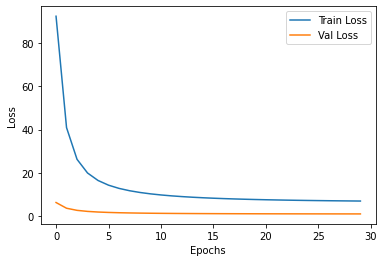

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), training_loss, label='Train Loss')
plt.plot(range(epochs), validation_loss, label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Testing using the learned model

In [ ]:
def get_test_scores(masked_sentence, masked_words):
  scores = []
  word_preds, logits = get_test_logits(masked_sentence)
  for j in range(len(word_preds)):
    score = []
    for k in range(len(word_preds[j])):
      score.append(get_input_row(masked_words[j], word_preds[j][k], logits[j][k]))
    scores.append(torch.tensor(score))
  return scores, word_preds

In [ ]:
replace_dict = {'u':'you','u.':'you.','m':'am','d':'the','y':'why','nt':'not','c':'see','ur':'your','r':'are', 'b':"be"}

ml_model = torch.load('gdrive/MyDrive/685/models/ml_model.pt')
ml_model.eval()

## Load the dataset here
path = 'gdrive/MyDrive/685/dataset/xsum_test.csv'
unnorm_col_name, delim = 'text', '\t'
normalized_text = []
count = 0
test_data = pd.read_csv(path, delimiter=delim)
test_data = test_data.iloc[:1000]

print("Normalizing the sentences...")
with torch.no_grad():
    for row_idx, row in test_data.iterrows():
        if count%100 == 0:
            print(f"{count}/{len(test_data)}")
        normalized_sents = []
        sentence = row[unnorm_col_name]
        cw_out = []
        sentence = sentence.replace("'",'')
        sentence = sentence.replace("`",'')
        sentence = sentence.replace('"','')
        temp_sent = []
        for idx, word in enumerate(sentence.split()):
            word = word.lower()
            if word in replace_dict:
                temp_sent.append(replace_dict[word])
                cw_out.append(replace_dict[word])
            else:
                temp_sent.append(word)
        sent = ' '.join(temp_sent)
        probs, words_ids = get_mask_words_ids(sent)
        unnorm_words = nltk.word_tokenize(sent)
        n = probs.shape[0]
        mask_idxs = []
        masked_words = []
        added = set()

        flag = False
        for i in range(n):
            if probs[i][1] >= 0.5:
                if words_ids[i] not in added:
                    if words_ids[i] >= len(unnorm_words):
                        flag = True
                        break
                    masked_words.append(unnorm_words[words_ids[i]])
                    unnorm_words[words_ids[i]] = '[MASK]'
                    mask_idxs.append(words_ids[i])
                    added.add(words_ids[i])
        if flag:
            normalized_text.append('')
            continue
        masked_sentence = ' '.join(unnorm_words)
        scores, word_preds = get_test_scores(masked_sentence, masked_words)

        for i in range(len(scores)):
            input = scores[i].to(device)
            output = ml_model(input)
            label_idx = torch.argmax(output)
            unnorm_words[mask_idxs[i]] = word_preds[i][label_idx]
            cw_out.append(word_preds[i][label_idx])
        norm_out = ' '.join(unnorm_words)

        normalized_text.append(norm_out)
        count += 1

test_data['output'] = normalized_text
print("Normalization completed!")

Normalizing the sentences...
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
Normalization completed!


In [ ]:
test_data.to_csv('gdrive/MyDrive/685/dataset/xsum_test_out_mlm.csv')

In [ ]:
import difflib

def get_dissimilar_spans(orig_words, gt_words, pred_words):
  gt_matcher = difflib.SequenceMatcher(a=orig_words, b=gt_words)
  pred_matcher = difflib.SequenceMatcher(a=gt_words, b=pred_words)
  orig_spans = []
  gt_spans = []
  pred_spans = []
  mismatch_spans = []
  for codes in gt_matcher.get_opcodes():
    op,a_start,a_end,b_start,b_end = codes
    if op == 'replace':
      orig_spans.append(" ".join(orig_words[a_start:a_end]))
      gt_spans.append(" ".join(gt_words[b_start:b_end]))

  for codes in pred_matcher.get_opcodes():
    op,a_start,a_end,b_start,b_end = codes
    if op == 'replace':
      pred_spans.append(" ".join(pred_words[b_start:b_end]))
      mismatch_spans.append(" ".join(gt_words[a_start:a_end]))
  
  return orig_spans, gt_spans, pred_spans, mismatch_spans

def get_stats_for_predictions(orig_text, gt_text, pred_text):
  try:
    orig_words = nltk.word_tokenize(orig_text)
    gt_words = nltk.word_tokenize(gt_text)
    pred_words = nltk.word_tokenize(pred_text)
  except:
    print(pred_text)
    print('-'*80)
  orig_words = [word.lower().strip() for word in orig_words]
  gt_words = [word.lower().strip() for word in gt_words]
  pred_words = [word.lower().strip() for word in pred_words]
  correct_preds = []
  wrong_preds = []
  changed_orig_words = []
  changed_gt_words = []
  replaced_word_cnt = 0
  correct_pred_cnt = 0
  if len(orig_words)!= len(gt_words):
    print(orig_text)
    print(gt_text)
  elif len(gt_words)!=len(pred_words):
    orig_spans, gt_spans, pred_spans, mismatch_spans = get_dissimilar_spans(orig_words, gt_words, pred_words)
    wrong_preds = pred_spans
    changed_orig_words = orig_spans
    changed_gt_words = gt_spans
    replaced_word_cnt = len(gt_spans)
    correct_pred_cnt = len(gt_spans) - len(mismatch_spans)
    correct_preds = list(set(gt_spans)-set(mismatch_spans))
  else:
    for i in range(len(orig_words)):
      orig_word = orig_words[i]
      gt_word = gt_words[i]
      pred_word = pred_words[i]
      if orig_word != gt_word:
        changed_orig_words.append(orig_word)
        changed_gt_words.append(gt_word)
        replaced_word_cnt = replaced_word_cnt+1
        if pred_word == gt_word:
          correct_preds.append(pred_word)
          correct_pred_cnt = correct_pred_cnt+1
        else:
          wrong_preds.append(pred_word)

  return {"replaced_gt_words":changed_gt_words,
          "replaced_original_words": changed_orig_words,
          "replaced_word_count": replaced_word_cnt,
          "correct_predictions": correct_preds,
          "correct_prediction_count": correct_pred_cnt,
          "wrong_predictions": wrong_preds}

def get_accuracy_df(pred_df):
  pred_df["Stats"] = pred_df.apply(lambda x: get_stats_for_predictions(x["text"], x["gt_text"],x["output"]), axis = 1)
  pred_df = pd.concat([pred_df.drop(['Stats'], axis=1), pred_df['Stats'].apply(pd.Series)], axis=1)
  return pred_df

## Evaluation on test data

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

pred_df = pd.read_csv('gdrive/MyDrive/685/dataset/xsum_test_out_mlm.csv')
pred_df = pred_df.fillna('')

acc_df = get_accuracy_df(pred_df)
print(f"Total incorrect tokens: {acc_df['replaced_word_count'].sum()}\n Total correct predictions: {acc_df['correct_prediction_count'].sum()} \nTest accuracy: {acc_df['correct_prediction_count'].sum()/acc_df['replaced_word_count'].sum()}")
acc_df = acc_df.drop(columns=['Unnamed: 0'])
display(acc_df.head())

Total incorrect tokens: 3995
 Total correct predictions: 3272 
Test accuracy: 0.8190237797246558


,text,gt_text,output,replaced_gt_words,replaced_original_words,replaced_word_count,correct_predictions,correct_prediction_count,wrong_predictions
0,A man who hit his university lecturer wife in de head with a hammer as she slept has been found guilty f attemptingg toooo mrdr herr.,A man who hit his university lecturer wife in the head with a hammer as she slept has been found guilty of attempting to murder her.,a man who hit his university lecturer wife in the head with a hammer as she slept has been found guilty of attempting to murder error .,"[the, of, attempting, to, murder, her]","[de, f, attemptingg, toooo, mrdr, herr]",6,"[the, of, attempting, to, murder]",5,[error]
1,Barrie McKay says he had to levae Rangers fOr Nottingham Forest this summer because of the way h was being tratd by new mnager Pedro Caixinha.,Barrie McKay says he had to leave Rangers for Nottingham Forest this summer because of the way he was being treated by new manager Pedro Caixinha.,barrie mckay says he had to leave rangers for nottingham forest this summer because of the way he was being treated by new manager pedro martinez .,"[leave, he, treated, manager]","[levae, h, tratd, mnager]",4,"[leave, he, treated, manager]",4,[]
2,"Wasps fans may nottt want to hear it, bt with Harlequins having won the Premiership title in 2012, succeeIdng Saracens as champions n the process, Saturdays match is now THEE London dddreby.","Wasps fans may not want to hear it, but with Harlequins having won the Premiership title in 2012, succeeding Saracens as champions in the process, Saturdays match is now THE London derby.","wasps fans may not want to hear it , but with harlequins having won the premiership title in 2012 , succeeding saracens as champions in the process , saturdays match is now the london derby .","[not, but, succeeding, in, the, derby]","[nottt, bt, succeeidng, n, thee, dddreby]",6,"[not, but, succeeding, in, the, derby]",6,[]
3,"Bradley Dack, Jake Hessenthaler nd Ryan Jackson scored as Gillingham came from behindddd to beat Swindon.","Bradley Dack, Jake Hessenthaler and Ryan Jackson scored as Gillingham came from behind to beat Swindon.","bradley davis , jake hunter and ryan jackson scored as gillingham came from behind to beat swindon .","[and, behind]","[nd, behindddd]",2,"[and, behind]",2,[]
4,"Arrangemetns will be made for th Family of on of those who died in the Grenfell Tower fire to travel from Syria to the UK for hiss funeral, thhE Home Office has said.","Arrangements will be made for the family of one of those who died in the Grenfell Tower fire to travel from Syria to the UK for his funeral, the Home Office has said.","arrangements will be made for the family of one of those who died in the green tower fire to travel from syria to the uk for his funeral , the home office has said .","[arrangements, the, one, his, the]","[arrangemetns, th, on, hiss, thhe]",5,"[arrangements, the, one, his, the]",5,[]


## Correctly Normalized sentences

In [ ]:
acc_df[acc_df['replaced_word_count']==acc_df['correct_prediction_count']]\
  .drop(columns=['replaced_original_words','replaced_word_count',
               'correct_prediction_count','wrong_predictions']).head()

,text,gt_text,output,replaced_gt_words,correct_predictions
1,Barrie McKay says he had to levae Rangers fOr Nottingham Forest this summer because of the way h was being tratd by new mnager Pedro Caixinha.,Barrie McKay says he had to leave Rangers for Nottingham Forest this summer because of the way he was being treated by new manager Pedro Caixinha.,barrie mckay says he had to leave rangers for nottingham forest this summer because of the way he was being treated by new manager pedro martinez .,"[leave, he, treated, manager]","[leave, he, treated, manager]"
2,"Wasps fans may nottt want to hear it, bt with Harlequins having won the Premiership title in 2012, succeeIdng Saracens as champions n the process, Saturdays match is now THEE London dddreby.","Wasps fans may not want to hear it, but with Harlequins having won the Premiership title in 2012, succeeding Saracens as champions in the process, Saturdays match is now THE London derby.","wasps fans may not want to hear it , but with harlequins having won the premiership title in 2012 , succeeding saracens as champions in the process , saturdays match is now the london derby .","[not, but, succeeding, in, the, derby]","[not, but, succeeding, in, the, derby]"
3,"Bradley Dack, Jake Hessenthaler nd Ryan Jackson scored as Gillingham came from behindddd to beat Swindon.","Bradley Dack, Jake Hessenthaler and Ryan Jackson scored as Gillingham came from behind to beat Swindon.","bradley davis , jake hunter and ryan jackson scored as gillingham came from behind to beat swindon .","[and, behind]","[and, behind]"
4,"Arrangemetns will be made for th Family of on of those who died in the Grenfell Tower fire to travel from Syria to the UK for hiss funeral, thhE Home Office has said.","Arrangements will be made for the family of one of those who died in the Grenfell Tower fire to travel from Syria to the UK for his funeral, the Home Office has said.","arrangements will be made for the family of one of those who died in the green tower fire to travel from syria to the uk for his funeral , the home office has said .","[arrangements, the, one, his, the]","[arrangements, the, one, his, the]"
5,Hungarys prliamnt haS rejected an attempttt by Prr Minister Viktor Orban t block the settlement of refugees.,Hungarys parliament has rejected an attempt by Prime Minister Viktor Orban to block the settlement of refugees.,hungarys parliament has rejected an attempt by prime minister viktor horn to block the settlement of refugees .,"[parliament, attempt, prime, to]","[parliament, attempt, prime, to]"


## Incorrectly normalized sentences

In [ ]:
incorrect_df = acc_df[acc_df['replaced_word_count']!=acc_df['correct_prediction_count']]\
  .drop(columns=['replaced_original_words','replaced_word_count',
               'correct_prediction_count'])
incorrect_df.head()

,text,gt_text,output,replaced_gt_words,correct_predictions,wrong_predictions
0,A man who hit his university lecturer wife in de head with a hammer as she slept has been found guilty f attemptingg toooo mrdr herr.,A man who hit his university lecturer wife in the head with a hammer as she slept has been found guilty of attempting to murder her.,a man who hit his university lecturer wife in the head with a hammer as she slept has been found guilty of attempting to murder error .,"[the, of, attempting, to, murder, her]","[the, of, attempting, to, murder]",[error]
7,Stepping off a bus atttt the Arc De Triomphe On Srdyyyy niGht felt more like Belfast in the 1970s than Paris in The 21st Century.,Stepping off a bus at the Arc De Triomphe on Saturday night felt more like Belfast in the 1970s than Paris in the 21st Century.,stepping off a bus at the arc de triomphe on friday night felt more like belfast in the 1970s than paris in the 21st century .,"[at, saturday]",[at],[friday]
15,The UN ’ s new cliiimatee chief says she ’ s worried about President Donald Trump - butt confident that action to crb climate chan is unstoppable.,The UN’s new climate chief says she’s worried about President Donald Trump - but confident that action to curb climate change is unstoppable.,the un ’ -sc new cia chief says she ’ s worried about president donald trump - butt confident that action to crb climate chan is unstoppable .,"[climate, but, curb, change]",[],"[cia, butt, crb, chan]"
18,Two sschoolboyss hhhad a Brownlee brothrs moment when one carried theee other Across the fiinshing line.,Two schoolboys had a Brownlee brothers moment when one carried the other across the finishing line.,two boys had a brownlee browndae moment when one carried the other across the fishing line .,"[schoolboys, had, brothers, the, finishing]","[had, the]","[boys, browndae, fishing]"
20,"A schools drawing of ADmiral Lord Nelson has ben valued at £010,000 by an expert n the Antiques Roadshow.","A schools drawing of Admiral Lord Nelson has been valued at £100,000 by an expert on the Antiques Roadshow.",a schools drawing of admiral lord nelson has been valued at £100 by an expert n the antiques roadshow .,"[been, £100,000, on]",[been],"[£100, n]"
